(monte-carlo)=
# Monte Carlo and Option Pricing

## Overview

Simple probability calculations can be done either

* with pencil and paper, or
* by looking up facts about well known probability distributions, or
* in our heads.

For example, we can easily work out

* the probability of three heads in five flips of a fair coin
* the expected value of a random variable that equals $-10$ with probability
  $1/2$ and $100$ with probability $1/2$.

But some probability calculations are very complex.

Complex calculations concerning probabilities and expectations occur in many
economic and financial problems.

Perhaps the most important tool for handling complicated probability
calculations is [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method).

In this lecture we introduce Monte Carlo methods for computing expectations,
with some applications in finance.

We will use the following imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn

## An introduction to Monte Carlo

In this section we describe how Monte Carlo can be used to compute
expectations.

### Share price with known distribution

Suppose that we are considering buying a share in some company.

Our plan is either to

1. buy the share now, hold it for one year and then sell it, or
2. do something else with our money.

We start by thinking of the share price in one year as a random variable $S$.

Before deciding whether or not to buy the share, we need to know some features
of the distribution of $S$.

For example, suppose the mean of $S$ is high relative to the price of buying
the share.

This suggests we have a good chance of selling at a relatively high price.

Suppose, however, that the variance of $S$ is also high.

This suggests that buying the share is risky, so perhaps we should refrain.

Either way, this discussion shows the importance of understanding the
distribution of $S$.

Suppose that, after analyzing the data, we guess that $S$ is well
represented by a lognormal distribution with parameters $\mu, \sigma$ .

* $S$ has the same distribution as $\exp(\mu + \sigma Z)$ where $Z$ is standard normal.
* We write this statement as $S \sim LN(\mu, \sigma)$.

Any good reference on statistics (such as
[Wikipedia](https://en.wikipedia.org/wiki/Log-normal_distribution)) will tell
us that the mean and variance are

$$
    \mathbb E S
        = \exp \left(\mu + \frac{\sigma^2}{2} \right)
$$

and

$$
    \mathop{\mathrm{Var}} S
    = [\exp(\sigma^2) - 1] \exp(2\mu + \sigma^2)
$$

So far we have no need for a computer.



### Share price with unknown distribution

But now suppose that we study the distribution of $S$ more carefully.

We decide that the share price depends on three variables, $X_1$, $X_2$, and
$X_3$ (e.g., sales, inflation, and interest rates).

In particular, our study suggests that

$$
    S = (X_1 + X_2 + X_3)^p
$$

where

* $p$ is a positive number, which is known to us  (i.e., has been estimated),
* $X_i \sim LN(\mu_i, \sigma_i)$ for $i=1,2,3$,
* the values $\mu_i, \sigma_i$ are also known, and
* the random variables $X_1$, $X_2$ and $X_3$ are independent.

How should we compute the mean of $S$?

To do this with pencil and paper is hard (unless, say, $p=1$).

But fortunately there's an easy way to do this, at least approximately.

This is the Monte Carlo method, which runs as follows:

1. Generate $n$ independent draws of $X_1$, $X_2$ and $X_3$ on a computer,
1. use these draws to generate $n$ independent draws of $S$, and
1. take the average value of these draws of $S$.

This average will be close to the true mean when $n$ is large.

This is due to the law of large numbers, which we discussed in {doc}`lln_clt`.

We use the following values for $p$ and each $\mu_i$ and $\sigma_i$.

In [2]:
n = 1_000_000
p = 0.5
μ_1, μ_2, μ_3 = 0.2, 0.8, 0.4
σ_1, σ_2, σ_3 = 0.1, 0.05, 0.2

#### A routine using loops in python


Here's a routine using native Python loops to calculate the desired mean

$$
    \frac{1}{n} \sum_{i=1}^n S_i
    \approx \mathbb E S
$$

In [3]:
%%time

S = 0.0
for i in range(n):
    X_1 = np.exp(μ_1 + σ_1 * randn())
    X_2 = np.exp(μ_2 + σ_2 * randn())
    X_3 = np.exp(μ_3 + σ_3 * randn())
    S += (X_1 + X_2 + X_3)**p
S / n

CPU times: user 3.62 s, sys: 3.6 ms, total: 3.62 s
Wall time: 3.62 s


2.229616987742987

We can also construct a function that contains these operations:

In [4]:
def compute_mean(n=1_000_000):
    S = 0.0
    for i in range(n):
        X_1 = np.exp(μ_1 + σ_1 * randn())
        X_2 = np.exp(μ_2 + σ_2 * randn())
        X_3 = np.exp(μ_3 + σ_3 * randn())
        S += (X_1 + X_2 + X_3)**p
    return (S / n)

Now let's call it.

In [5]:
compute_mean()

2.2297481243996313

### A vectorized routine

If we want a more accurate estimate we should increase $n$.

But the code above runs quite slowly.

To make it faster, let's implement a vectorized routine using NumPy.

In [6]:
def compute_mean_vectorized(n=1_000_000):
    X_1 = np.exp(μ_1 + σ_1 * randn(n))
    X_2 = np.exp(μ_2 + σ_2 * randn(n))
    X_3 = np.exp(μ_3 + σ_3 * randn(n))
    S = (X_1 + X_2 + X_3)**p
    return S.mean()

In [7]:
%%time

compute_mean_vectorized()

CPU times: user 72.3 ms, sys: 11.9 ms, total: 84.1 ms
Wall time: 83.9 ms


2.229751440589362

Notice that this routine is much faster.

We can increase $n$ to get more accuracy and still have reasonable speed:

In [8]:
%%time

compute_mean_vectorized(n=10_000_000)

CPU times: user 775 ms, sys: 59.9 ms, total: 835 ms
Wall time: 834 ms


2.229733033482732

## Pricing a European call option under risk neutrality

Next we are going to price a European call option under risk neutrality.

Let's first discuss risk neutrality and then consider European options.



### Risk-neutral pricing

When we use risk-neutral pricing, we determine the price of a given asset
according to its expected payoff:

$$
\text{cost } = \text{ expected benefit}
$$

For example, suppose someone promises to pay you

- 1,000,000 dollars if "heads" is the outcome of a fair coin flip
- 0 dollars if "tails" is the outcome

Let's denote the payoff as $G$, so that

$$
    \mathbb P\left\{G = 10^6 \right\} = \mathbb P\{G = 0\} = \frac{1}{2}
$$

Suppose in addition that you can sell this promise to anyone who wants it.

- First they pay you $P$, the price at which you sell it
- Then they get $G$, which could be either 1,000,000 or 0.

What's a fair price for this asset (this promise)?

The definition of "fair" is ambiguous, but we can say that the
**risk-neutral price** is 500,000 dollars.

This is because the risk-neutral price is just the expected payoff of the
asset, which is

$$
    \mathbb E G = \frac{1}{2} \times 10^6 + \frac{1}{2} \times 0 = 5 \times 10^5
$$



### A comment on risk

As suggested by the name, the risk-neutral price ignores risk.

To understand this, consider whether you would pay 500,000 dollars for such a
promise.

Would you prefer to receive 500,000 for sure or 1,000,000 dollars with
50% probability and nothing with 50% probability?

At least some readers will strictly prefer the first option --- although some
might prefer the second.

Thinking about this makes us realize that 500,000 is not necessarily the
"right" price --- or the price that we would see if there was a market for
these promises.

Nonetheless, the risk-neutral price is an important benchmark, which economists
and financial market participants try to calculate every day.



### Discounting

Another thing we ignored in the previous discussion was time.

In general, receiving $x$ dollars now is preferable to receiving $x$ dollars
in $n$ periods (e.g., 10 years).

After all, if we receive $x$ dollars now, we could put it in the bank at
interest rate $r > 0$ and receive $ (1 + r)^n x $ in $n$ periods.

Hence future payments need to be discounted when we consider their present
value.

We will implement discounting by

* multiplying a payment in one period by $\beta < 1$
* multiplying a payment in $n$ periods by $\beta^n$, etc.

The same adjustment needs to be applied to our risk-neutral price for the
promise described above.

Thus, if $G$ is realized in $n$ periods, then the risk-neutral price is

$$
    P = \beta^n \mathbb E G
      = \beta^n 5 \times 10^5
$$



### European call options

Now let's price a European call option.

The option is described by three things:

2. $n$, the **expiry date**,
2. $K$, the **strike price**, and
3. $S_n$, the price of the **underlying** asset at date $n$.

For example, suppose that the underlying is one share in Amazon.

The owner of this option has the right to buy one share in Amazon at price $K$ after $n$ days.

If $S_n > K$, then the owner will exercise the option, buy at $K$, sell at
$S_n$, and make profit $S_n - K$.

If $S_n \leq K$, then the owner will not exercise the option and the payoff is zero.

Thus, the payoff is $\max\{ S_n - K, 0 \}$.

Under the assumption of risk neutrality,  the price of the option is
the expected discounted payoff:

$$ P = \beta^n \mathbb E \max\{ S_n - K, 0 \} $$

Now all we need to do is specify the distribution of $S_n$, so the expectation
can be calculated.


Suppose we know that $S_n \sim LN(\mu, \sigma)$ and $\mu$ and $\sigma$ are known.

If $S_n^1, \ldots, S_n^M$ are independent draws from this lognormal distribution then, by the law of large numbers,

$$
    \mathbb E \max\{ S_n - K, 0 \}
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
$$

We suppose that

In [9]:
μ = 1.0
σ = 0.1
K = 1
n = 10
β = 0.95

We set the simulation size to

In [10]:
M = 10_000_000

Here is our code

In [11]:
S = np.exp(μ + σ * np.random.randn(M))
return_draws = np.maximum(S - K, 0)
P = β**n * np.mean(return_draws)
print(f"The Monte Carlo option price is approximately {P:3f}")

The Monte Carlo option price is approximately 1.036889


## Pricing via a dynamic model

In this exercise we investigate a more realistic model for the share price $S_n$.

This comes from specifying the underlying dynamics of the share price.

First we specify the dynamics.

Then we'll compute the price of the option using Monte Carlo.

### Simple dynamics

One simple model for $\{S_t\}$ is

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma \xi_{t+1} $$

where

* $S_0$ is lognormally distributed and
* $\{ \xi_t \}$ is IID and standard normal.


Under the stated assumptions, $S_n$ is lognormally distributed.

To see why, observe that, with $s_t := \ln S_t$, the price dynamics become

```{math}
:label: s_mc_dyms

s_{t+1} = s_t + \mu + \sigma \xi_{t+1}
```

Since $s_0$ is normal and $\xi_1$ is normal and IID, we see that $s_1$ is
normally distributed.

Continuing in this way shows that $s_n$ is normally distributed.

Hence $S_n = \exp(s_n)$ is lognormal.


### Problems with simple dynamics

The simple dynamic model we studied above is convenient, since we can work out
the distribution of $S_n$.


However, its predictions are counterfactual because, in the real world,
volatility (measured by $\sigma$) is not stationary.

Instead it rather changes over time, sometimes high (like during the GFC) and sometimes low.

In terms of our model above, this means that $\sigma$ should not be constant.


### More realistic dynamics

This leads us to study the improved version:

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1} $$

where

$$
    \sigma_t = \exp(h_t),
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$

Here $\{\eta_t\}$ is also IID and standard normal.



### Default parameters

For the dynamic model, we adopt the following parameter values.

In [12]:
default_μ  = 0.0001
default_ρ  = 0.1
default_ν  = 0.001
default_S0 = 10
default_h0 = 0

(Here `default_S0` is $S_0$ and `default_h0` is $h_0$.)

For the option we use the following defaults.

In [13]:
default_K = 100
default_n = 10
default_β = 0.95

### Visualizations

With $s_t := \ln S_t$, the price dynamics become

$$ s_{t+1} = s_t + \mu + \exp(h_t) \xi_{t+1} $$

Here is a function to simulate a path using this equation:

In [14]:
def simulate_asset_price_path(μ=default_μ, S0=default_S0, h0=default_h0, n=default_n, ρ=default_ρ, ν=default_ν):
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()

    return np.exp(s)

Here we plot the paths and the log of the paths.

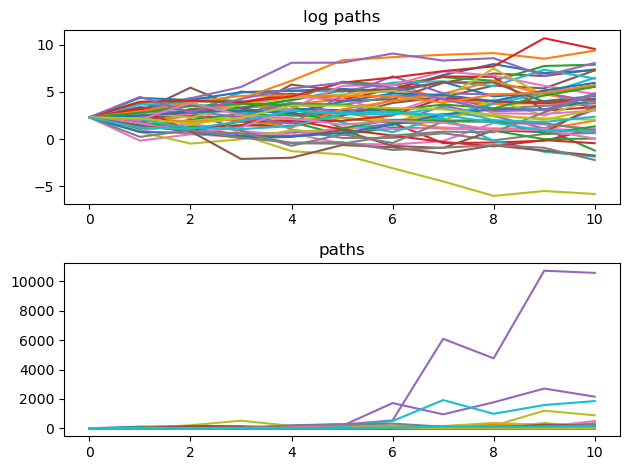

In [15]:
fig, axes = plt.subplots(2, 1)

titles = 'log paths', 'paths'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path()
        ax.plot(transform(path))
    ax.set_title(title)

fig.tight_layout()
plt.show()

### Computing the price

Now that our model is more complicated, we cannot easily determine the
distribution of $S_n$.

So to compute the price $P$ of the option, we use Monte Carlo.

We average over realizations $S_n^1, \ldots, S_n^M$ of $S_n$ and appealing to
the law of large numbers:

$$
    \mathbb E \max\{ S_n - K, 0 \}
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
$$


Here's a version using Python loops.

In [16]:
def compute_call_price(β=default_β,
                       μ=default_μ,
                       S0=default_S0,
                       h0=default_h0,
                       K=default_K,
                       n=default_n,
                       ρ=default_ρ,
                       ν=default_ν,
                       M=10_000):
    current_sum = 0.0
    # For each sample path
    for m in range(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)

    return β**n * current_sum / M

In [17]:
%%time
compute_call_price()

CPU times: user 186 ms, sys: 48 μs, total: 186 ms
Wall time: 185 ms


548.9079453230936

## Exercises

```{exercise}
:label: monte_carlo_ex1

We would like to increase $M$ in the code above to make the calculation more
accurate.

But this is problematic because Python loops are slow.

Your task is to write a faster version of this code using NumPy.
```

```{solution-start} monte_carlo_ex1
:class: dropdown
```

In [18]:
def compute_call_price_vector(β=default_β,
                       μ=default_μ,
                       S0=default_S0,
                       h0=default_h0,
                       K=default_K,
                       n=default_n,
                       ρ=default_ρ,
                       ν=default_ν,
                       M=10_000):

    s = np.full(M, np.log(S0))
    h = np.full(M, h0)
    for t in range(n):
        Z = np.random.randn(2, M)
        s = s + μ + np.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = np.mean(np.maximum(np.exp(s) - K, 0))

    return β**n * expectation

In [19]:
%%time
compute_call_price_vector()

CPU times: user 5.29 ms, sys: 33 μs, total: 5.32 ms
Wall time: 5.08 ms


644.5070918464787

Notice that this version is faster than the one using a Python loop.

Now let's try with larger $M$ to get a more accurate calculation.

In [20]:
%%time
compute_call_price(M=10_000_000)

CPU times: user 3min 7s, sys: 24.2 ms, total: 3min 7s
Wall time: 3min 7s


856.7178347535853

```{solution-end}
```

```{exercise}
:label: monte_carlo_ex2

Consider that a European call option may be written on an underlying with spot price of \$100 and a knockout barrier of \$120.

This option behaves in every way like a vanilla European call, except if the spot price ever moves above \$120, the option "knocks out" and the contract is null and void.

Note that the option does not reactivate if the spot price falls below \$120 again.

Use the dynamics defined in {eq}`s_mc_dyms` to price the European call option.
```

```{solution-start} monte_carlo_ex2
:class: dropdown
```

In [21]:
default_μ  = 0.0001
default_ρ  = 0.1
default_ν  = 0.001
default_S0 = 10
default_h0 = 0
default_K = 100
default_n = 10
default_β = 0.95
default_bp = 120

In [22]:
def compute_call_price_with_barrier(β=default_β,
                                    μ=default_μ,
                                    S0=default_S0,
                                    h0=default_h0,
                                    K=default_K,
                                    n=default_n,
                                    ρ=default_ρ,
                                    ν=default_ν,
                                    bp=default_bp,
                                    M=50_000):
    current_sum = 0.0
    # For each sample path
    for m in range(M):
        s = np.log(S0)
        h = h0
        payoff = 0
        option_is_null = False
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
            if np.exp(s) > bp:
                payoff = 0
                option_is_null = True
                break

        if not option_is_null:
            payoff = np.maximum(np.exp(s) - K, 0)
        # And add the payoff to current_sum
        current_sum += payoff

    return β**n * current_sum / M

In [23]:
%time compute_call_price_with_barrier()

CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.09 s


0.04004803897340941

Let's look at the vectorized version which is faster than using Python loops.

In [24]:
def compute_call_price_with_barrier_vector(β=default_β,
                                           μ=default_μ,
                                           S0=default_S0,
                                           h0=default_h0,
                                           K=default_K,
                                           n=default_n,
                                           ρ=default_ρ,
                                           ν=default_ν,
                                           bp=default_bp,
                                           M=50_000):
    s = np.full(M, np.log(S0))
    h = np.full(M, h0)
    option_is_null = np.full(M, False)
    for t in range(n):
        Z = np.random.randn(2, M)
        s = s + μ + np.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
        # Mark all the options null where S_n > barrier price
        option_is_null = np.where(np.exp(s) > bp, True, option_is_null)

    # mark payoff as 0 in the indices where options are null
    payoff = np.where(option_is_null, 0, np.maximum(np.exp(s) - K, 0))
    expectation = np.mean(payoff)
    return β**n * expectation

In [25]:
%time compute_call_price_with_barrier_vector()

CPU times: user 28.4 ms, sys: 0 ns, total: 28.4 ms
Wall time: 28.1 ms


0.03883870405359576

```{solution-end}
```